In [1]:
import os
import json
import torch
import pickle
import numpy as np
from PIL import Image, ImageFilter 
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 1.8 MB/s eta 0:00:0000:0100:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ijpuu202
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ijpuu202
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=a85bddd7576421df8d4a47f3fc8b23242e57635de767b5b996199985ebfe00c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6uyuun0/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


## Load the data from RefCOCOg

Here we load the annotation file with all the references and the images. Here the data loader class.

In [2]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
# Load refs and annotations
import pickle

with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("../extractCOCO/refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [4]:
# load the train dataset
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


### Functions to preprocess 

Here I am willing to preprocess the data, to avoid redundant computations during the training. With the data preprocessed we straightfowardly train the model without preprocess the data during the training.

In [10]:
import clip
import torch
import time
# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# https://github.com/baaivision/EVA/tree/master/EVA-CLIP
# https://huggingface.co/QuanSun/EVA-CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

# load the model from the torch hub
clip_model, preprocess = clip.load("RN50", device=device)
detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True).cuda()


#####################################################

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#####################################################

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

#####################################################

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

#####################################################

def detect(im, model, transform, device):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    # assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5
    # keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)
    return probas[keep], bboxes_scaled

#####################################################

def blur_out_detr(image, box):
    """ Blur the image out of the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(image))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_max)
    x_1, x_2 = int(x_min), int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

    # return the image blurred
    return Image.fromarray(im)

#####################################################

def blur_in_detr(image, box):
    """ Blur the image in the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(image))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_max)
    x_1, x_2 = int(x_min), int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]

    # blur the image in the box
    remove_box = np.array(image)-mask
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))
    remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

    return Image.fromarray(remove_box)

#####################################################

def get_img_blur_outin(Images, detected):
    """ Return a list of tuple of pillow images
    [[(blur_out, blur_in),...],[...]] 
    Dimensions of the list:
        dim_1: number of images
        dim_2: number of boxes found by detr
    Args:
        


    """
    return [[(blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist()))
                for idx in range(len(d[1]))]
                    for I, d in zip(Images, detected)]

#####################################################

def get_img_blur_outin_preprocessed(Images, detected):
    """Return a list of tuple of pillow images preprocessed
    with CLIP preprocessor

    Args:
        Images (list): list of pillow images
        detected (list): list of detected boxes with detr

    Returns:
        _list_: list of preprocessed images blur_out, blur_in
    """
    return [[torch.stack([preprocess(i).unsqueeze(0) 
                for i in [blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist())]]).squeeze(1)
                for idx in range(len(d[1]))]
                for I, d in zip(Images, detected)]

#####################################################

def get_listed_img_blur_outin(Images, detected):
    """ Return the list of list with the boxex
    blurd in, blurd out.

    example:
        [   
           [
            [list of img with box blurd out],
            [list of img with box blurd in]
           ],
           [
            [list of img with box blurd out],
            [list of img with box blurd in]
           ],
           ...
        ]
    Args:
        Images (list): list of pillow images
        detected (list): list of detected boxes with detr

    Returns:
        _list_: list of list of images blur_out, blur_in
    
    """
    
    return [[torch.stack([i[0] for i in img]), # blur out 
            torch.stack([i[1] for i in img])] # blurd in
                for img in get_img_blur_outin_preprocessed(Images, detected)]

#####################################################

def get_prob_clip(clip, clip_model, samples_json, blur_outin, offset, device):
    
    probabilities = []
    for idx, sample in enumerate(blur_outin):
        text = clip.tokenize([samples_json[idx+offset]["caption"]]).to(device)

        # to do not keep track of the computational
        # graph to compute the gradients
        with torch.no_grad():
            _, logits_per_text_blur_out = clip_model(sample[0].to(device), text)
            _, logits_per_text_blur_in = clip_model(sample[1].to(device), text)
            probs_blur_out = logits_per_text_blur_out.softmax(dim=-1).cpu().numpy().round(4).type(torch.float16)
            probs_blur_in = logits_per_text_blur_in.softmax(dim=-1).cpu().numpy().round(4).type(torch.float16)
            probs = torch.stack([probs_blur_out, probs_blur_in])
        probabilities.append(probs.squeeze(1))

    return probabilities

#####################################################

# load a batch of 10 images
N_images = 10

start = time.time()
# load the images
Images = [Image.open('../extractCOCO/'+sample["file_name"][1:]) for sample in train_dataset[:N_images]]
end = time.time()
print(f'time to load {N_images} images: ',round(end - start,2))

start = time.time()
# detect the boxes
detected = [detect(im, detr, transform, device) for im in Images]
end = time.time()
print(f'time to detect the boxes in {N_images} images: ',round(end - start,2))

start = time.time()
blur_outin = get_listed_img_blur_outin(Images, detected)
end = time.time()
print(f'time to blur the images in {N_images} images: ',round(end - start,2))


Using device: cuda


Using cache found in /home/rickbook/.cache/torch/hub/facebookresearch_detr_main
/home/rickbook/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rickbook/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


time to load 10 images:  0.0
time to detect the boxes in 10 images:  0.92
time to blur the images in 10 images:  5.1


Compute the probabilities with clip with the images blurred out and in.

In [19]:
def get_prob_clip(clip, clip_model, samples_json, blur_outin, offset, device):
    
    probabilities = []
    for idx, sample in enumerate(blur_outin):
        text = clip.tokenize([samples_json[idx+offset]["caption"]]).to(device)

        # to do not keep track of the computational
        # graph to compute the gradients
        with torch.no_grad():
            _, logits_per_text_blur_out = clip_model(sample[0].to(device), text)
            _, logits_per_text_blur_in = clip_model(sample[1].to(device), text)
            probs_blur_out = logits_per_text_blur_out.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
            probs_blur_in = logits_per_text_blur_in.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
            probs = np.stack([probs_blur_out, probs_blur_in])
        probabilities.append(probs.squeeze(1))

    return probabilities

# get training data
start = time.time()
probabilities = get_prob_clip(clip, clip_model, train_dataset, blur_outin, 0, device)
end = time.time()
print(f'time to get the probabilities in {N_images} images: ',round(end - start,2))

time to get the probabilities in 10 images:  0.88


Here I combine the probabilities with the respective bounding box.

In [13]:
def get_prob_box(probabilities, boxes):
    prob_box = []

    for p, b in zip(probabilities, boxes):
        # print(torch.from_numpy(p).shape,b.cpu().permute(1,0).shape)
        # print(torch.concat([torch.from_numpy(p),b.cpu().permute(1,0)],0).permute(1,0).shape)

        # to get the boxes in the refCOCO format
        # x_min, y_min, x_max-x_min, y_max-y_min
        b[:,2] = b[:,2] - b[:,0]
        b[:,3] = b[:,3] - b[:,1]
        
        # concat the boxes and the probabilities
        prob_box.append(torch.concat([torch.from_numpy(p),b.cpu().permute(1,0)],0).permute(1,0))
    return prob_box

start = time.time()
prob_box = get_prob_box(probabilities, boxes)
end = time.time()
print(f'time to match the prob with boxes with {N_images} images: ',round(end - start,2))


print('number of images:', len(prob_box))
print('shape: (number of boxes for each image 0, blur_out_in probability clip + boxes) :', prob_box[0].shape)

time to match the prob with boxes with 10 images:  0.0
number of images: 10
shape: (number of boxes for each image 0, blur_out_in probability clip + boxes) : torch.Size([13, 6])


In [12]:
print('number of images:', len(probabilities))
print('shape: (blur_out_in, number of boxes for each image 0) :', probabilities[0].shape)


number of images: 10
shape: (blur_out_in, number of boxes for each image 0) : (2, 13)


In [16]:
prob_box[0][:3,:] # first 3 boxes of the image 0 with the probabilities

tensor([[ 5.0020e-04,  7.8011e-03, -9.8633e-02,  2.4075e+02,  2.1512e+02,
          2.3450e+02],
        [ 2.0003e-04,  2.0401e-02,  4.6050e+02,  4.1625e+02,  3.7500e+01,
          4.1750e+01],
        [ 1.0002e-04,  1.3603e-02,  2.6325e+02,  4.2625e+02,  1.0025e+02,
          5.3250e+01]], dtype=torch.float16)

Here, I tried to combine the two functions above, to reduce the number of loops and make the processing more efficient.

In [102]:
def get_prob_boxes_clip(clip, clip_model, samples_json, blur_outin, device, boxes):
    
    # probabilities_boxes = []
    dict_prob_boxes = {}
    for idx, (sample, b) in enumerate(zip(blur_outin, boxes)):
        text = clip.tokenize([samples_json[idx]["caption"]]).to(device)

        # to do not keep track of the computational
        # graph to compute the gradients
        with torch.no_grad():
            emb_blur_out = clip_model.encode_image(sample[0].to(device)) # get embeddings blur_out
            emb_text = clip_model.encode_text(text) # get embeddings text
            _, logits_per_text_blur_out = clip_model(sample[0].to(device), text)
            _, logits_per_text_blur_in = clip_model(sample[1].to(device), text)
            probs_blur_out = logits_per_text_blur_out.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
            probs_blur_in = logits_per_text_blur_in.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
            probs = np.stack([probs_blur_out, probs_blur_in])
        # to get the boxes in the refCOCO format
        # x_min, y_min, x_max-x_min, y_max-y_min
        b[:,2] = b[:,2] - b[:,0]
        b[:,3] = b[:,3] - b[:,1]
        # probabilities_boxes.append(torch.concat([torch.from_numpy(probs.squeeze(1)),b.cpu().permute(1,0)],0).permute(1,0))
        temp = dict()
        temp['prob-box-map'] = torch.concat([torch.from_numpy(probs.squeeze(1)),b.cpu().permute(1,0)],0).permute(1,0)
        temp['embeds-boxes'] = emb_blur_out
        temp['embeds-caption'] = emb_text

        dict_prob_boxes[idx] = temp

    return dict_prob_boxes

boxes = [d[1].round().type(torch.float16) for d in detected]

# get training data
start = time.time()
dict_prob_boxes = get_prob_boxes_clip(clip, clip_model, train_dataset, blur_outin, device, boxes)
end = time.time()
print(f'time to get the probabilities in {N_images} images: ',round(end - start,2))

time to get the probabilities in 10 images:  1.25


Here I show why this could works. The patterns that we are searching for 

In [103]:
dict_prob_boxes[0]['prob-box-map'][:,:2].numpy().round(2) 

array([[0.  , 0.01],
       [0.  , 0.02],
       [0.  , 0.01],
       [0.  , 0.07],
       [0.17, 0.  ],
       [0.  , 0.03],
       [0.83, 0.  ],
       [0.  , 0.02],
       [0.  , 0.  ],
       [0.  , 0.01],
       [0.  , 0.1 ],
       [0.  , 0.39],
       [0.  , 0.34]], dtype=float16)

In [104]:
# here i'm showing that the boxes concatenated with the probabilities are the same of the 
# boxes founded by detr
print(detected[0][1])
print(dict_prob_boxes[0]['prob-box-map'][:,2:])

tensor([[-9.8610e-02,  2.4073e+02,  2.1495e+02,  4.7533e+02],
        [ 4.6054e+02,  4.1637e+02,  4.9807e+02,  4.5812e+02],
        [ 2.6330e+02,  4.2627e+02,  3.6341e+02,  4.7962e+02],
        [ 3.8759e+02,  3.5774e+02,  5.9652e+02,  4.7657e+02],
        [ 1.3628e+02,  3.8849e+01,  3.0385e+02,  2.2315e+02],
        [ 9.8347e+01,  2.3838e+02,  2.1688e+02,  3.6867e+02],
        [ 1.3610e+00,  4.3316e+01,  2.3957e+02,  4.6619e+02],
        [ 1.6225e+02,  1.1971e+02,  1.9994e+02,  1.5294e+02],
        [ 1.4388e+02,  1.3100e+02,  6.1088e+02,  4.7454e+02],
        [ 2.1928e+02,  1.7334e+02,  2.9209e+02,  2.5041e+02],
        [ 3.8700e+02,  1.2051e+00,  6.3903e+02,  3.1224e+02],
        [ 1.9631e+02,  2.1373e+02,  5.5549e+02,  4.5015e+02],
        [ 3.7335e+02,  1.9537e+00,  6.3954e+02,  4.7448e+02]], device='cuda:0')
tensor([[ -0., 241., 215., 234.],
        [461., 416.,  37.,  42.],
        [263., 426., 100.,  54.],
        [388., 358., 209., 119.],
        [136.,  39., 168., 184.],
      

In [105]:
# here we could see that the box which show this particular pattern in term of the score 
# is actually the box which is the most probable to be the correct one
print(detected[0][1][6]) # here the boxes are not converted in the refCOCO format
        # # to get the boxes in the refCOCO format
        # # x_min, y_min, x_max-x_min, y_max-y_min
        # b[:,2] = b[:,2] - b[:,0]
        # b[:,3] = b[:,3] - b[:,1]


print(dict_prob_boxes[0]['prob-box-map'][:,2:][6]) # boxes converted in the refCOCO format
print(train_dataset[0]['bbox'])

tensor([  1.3610,  43.3157, 239.5703, 466.1932], device='cuda:0')
tensor([  1.,  43., 239., 423.], dtype=torch.float16)
[0.0, 45.95, 238.92, 408.64]


Two woman one in black eatting and the other has a white shirt at the desk
torch.Size([1, 1024])


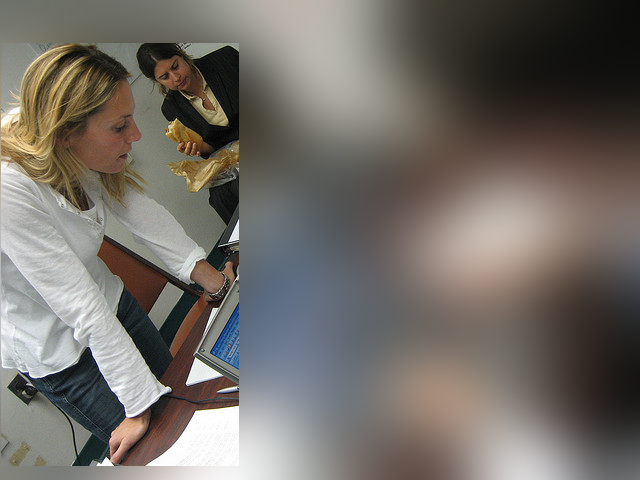

In [106]:
print(train_dataset[0]['caption'])
print(dict_prob_boxes[0]['embeds-caption'].shape)
get_img_blur_outin(Images, detected)[0][6][0]

In [87]:
imm = get_img_blur_outin(Images, detected)[0]

In [107]:
import pickle


open('dict_prob_boxes.pkl', 'wb').write(pickle.dumps(dict_prob_boxes))

295313